# Analyzing the embeddings

This notebook pretends to analyze the output of the get_embeddings script evaluating them with a dataset

In [28]:
# Library imports
import os
import glob

import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from sentence_transformers import util

In [ ]:
# Global variables
MODEL = 'Qwen3-Embedding-0.6B-f16'
DATA_PATH = '../data'
DATA_EMBEDDINGS_PATH = f'../data_embeddings/{MODEL}'
DATASET_EMBEDDINGS_PATH = f'../dataset_embeddings/{MODEL}'
DATASET_NAME = 'Rivert97/ug-normativity'
RESULTS_DIR = '../results'

# Other variables
k = 5
file_excludes = ['reglamento-de-responsabilidades-en-el-entorno-universitario-de-la-universidad-de-guanajuato']

In [30]:
# Loading questions dataset
dataset = load_dataset(DATASET_NAME)
dataset = dataset['train']

In [31]:
dataset

Dataset({
    features: ['id', 'title', 'context', 'additional_context', 'question', 'answers'],
    num_rows: 1836
})

In [32]:
all_data = []
all_embeddings = []
all_questions_embeddings = []

# Loading the data
for data_filename in glob.glob(os.path.join(DATA_PATH, '*.csv')):
    embeddings_filename = os.path.join(DATA_EMBEDDINGS_PATH, os.path.split(data_filename)[1])
    questions_filename = os.path.join(DATASET_EMBEDDINGS_PATH, os.path.split(data_filename)[1])
    print(questions_filename)

    if not os.path.exists(questions_filename):
        print(f"Ignoring file {data_filename}")
        file_excludes.append(os.path.splitext(os.path.split(data_filename)[1])[0])
        continue

    data = pd.read_csv(data_filename, sep=',')
    embeddings = pd.read_csv(embeddings_filename, sep=',', index_col=0)
    questions_embeddings = pd.read_csv(questions_filename, sep=',', index_col=0)

    all_data.append(data)
    all_embeddings.append(embeddings)
    all_questions_embeddings.append(questions_embeddings)

data = pd.concat(all_data, ignore_index=True)
embeddings = pd.concat(all_embeddings, ignore_index=True)
questions_embeddings = pd.concat(all_questions_embeddings)


../dataset_embeddings/Qwen3-Embedding-0.6B-Q8_0/ley-organica-de-la-universidad-de-guanajuato.csv
../dataset_embeddings/Qwen3-Embedding-0.6B-Q8_0/reglamento-del-personal-academico-de-la-universidad-de-guanajuato.csv
../dataset_embeddings/Qwen3-Embedding-0.6B-Q8_0/reglamento-de-distinciones-universitarias-de-la-universidad-de-guanajuato.csv
../dataset_embeddings/Qwen3-Embedding-0.6B-Q8_0/reglamento-de-la-junta-directiva-de-la-universidad-de-guanajuato.csv
../dataset_embeddings/Qwen3-Embedding-0.6B-Q8_0/reglamento-para-la-incorporacion-al-regimen-academico-de-la-universidad-de-guanajuato.csv
../dataset_embeddings/Qwen3-Embedding-0.6B-Q8_0/reglamento-interno-del-patronato-de-la-universidad-de-guanajuato.csv
../dataset_embeddings/Qwen3-Embedding-0.6B-Q8_0/reglamento-de-quienes-integran-la-orquesta-sinfonica-de-la-universidad-de-guanajuato_2021-2023.csv
../dataset_embeddings/Qwen3-Embedding-0.6B-Q8_0/reglamento-academico-de-la-universidad-de-guanajuato.csv
../dataset_embeddings/Qwen3-Embeddi

In [33]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,2.739067,-7.485513,-0.539649,0.687030,4.650545,-4.256957,2.355106,3.328069,6.664709,-3.517382,...,-1.519445,1.580063,-1.357517,2.742901,-3.123947,-3.895531,4.520152,0.145995,3.245127,0.561654
1,3.387160,-9.293532,-0.623536,-0.674491,6.986831,-5.936400,2.263434,2.316784,3.514602,-2.173984,...,0.935825,0.016146,0.071169,2.625589,-2.317709,-4.644685,6.880002,-2.645772,3.538184,1.590470
2,3.236006,-7.770414,-1.480498,2.014582,8.705091,-2.275473,-3.514220,-24.962410,2.350418,-9.597134,...,-7.254447,1.026621,-1.093382,3.946243,-0.888537,-2.954716,4.272441,-4.752322,3.640963,-0.850558
3,0.035412,-7.289517,-0.877361,0.062354,3.248761,-6.726335,2.603836,0.451991,3.332462,-1.658010,...,-1.506155,-0.615671,-0.663379,-1.926759,-2.221105,3.714441,-0.576872,1.861756,-2.198785,3.914874
4,3.016275,-5.342649,-1.066203,4.685660,3.407620,-5.762234,-4.161249,-6.523539,7.275693,1.292881,...,-2.676072,-3.499861,-1.797714,-0.082652,-3.487416,-2.332557,1.483773,0.657025,5.737261,0.436220


In [34]:
questions_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
81e729afa369916be4d4db99f9c1817c,0.077288,-10.530747,-0.043759,-1.599126,11.391203,-2.737590,-2.064302,4.373279,5.847192,-1.769834,...,-5.371327,1.337071,-3.581489,2.357342,-4.296686,-0.275876,6.504293,3.812421,-1.256873,0.372578
28738544e42b076370fc813c5711852a,-3.164372,-8.183681,0.087888,-1.123464,1.461937,-1.739206,-5.878028,1.063886,4.422995,-4.713903,...,-5.705910,-1.517223,-1.507199,4.125609,3.476329,1.512054,4.120256,-0.153344,1.165380,-4.262352
948cb616a68fe33024da19654b56a0b1,5.605330,-11.153820,-0.213153,-3.309761,11.487044,-5.078985,-1.089982,8.140415,8.750868,-4.415782,...,-5.442841,-0.383018,0.755105,0.498504,-6.074835,-2.428823,4.522166,6.016826,-6.655021,2.595288
e80f3ca8fb8791ca480ee02bf9250484,4.038774,-11.207958,0.048724,0.665261,16.421839,-4.411089,-1.848008,-0.008845,4.454969,5.016719,...,-5.863512,-1.225108,-1.819162,1.234608,-6.753408,-4.580499,3.716249,5.243552,-3.645065,0.737782
c1ca177b00aeae41aa361c243e612a9d,-1.729841,-14.140342,-0.051510,1.121900,10.334516,-1.887665,1.165766,-3.891111,-0.106689,-4.265732,...,-2.752210,-3.343086,0.419569,-0.131765,-4.922507,-2.012146,2.210651,3.249147,-3.556616,2.353125


In [35]:
# For each question find its chunk
questions = []

for question in dataset:
    if question['title'] in file_excludes:
        continue

    tmp_question = {
        'question': question,
        'question_embeddings': questions_embeddings.loc[question['id']].values,
        'chunk_idx': None,
        'chunk': None,
        'chunk_embeddings': None,
    }

    for chunk_idx, chunk in data.loc[data['document_name'] == question['title']].iterrows():
        if chunk['path'].lower().endswith(question['context'].lower().strip()):
            tmp_question['chunk_idx'] = chunk_idx
            tmp_question['chunk'] = chunk
            tmp_question['chunk_embeddings'] = embeddings.loc[chunk_idx].values
            break

    if tmp_question['chunk_idx'] is not None:
        questions.append(tmp_question)

print(questions[0])

{'question': {'id': '81e729afa369916be4d4db99f9c1817c', 'title': 'ley-organica-de-la-universidad-de-guanajuato', 'context': 'Artículo 1', 'additional_context': '', 'question': '¿Qué contiene la Ley Orgánica de la Universidad de Guanajuato?', 'answers': {'text': ['Contiene las normas fundamentales de la misión, organización, funcionamiento y gobierno de la Universidad de Guanajuato']}}, 'question_embeddings': array([  0.0772877 , -10.53074741,  -0.04375915, ...,   3.81242108,
        -1.25687265,   0.37257823], shape=(1024,)), 'chunk_idx': 7, 'chunk': document_name         ley-organica-de-la-universidad-de-guanajuato
title                                                   Artículo 1
path             /root/LEY ORGÁNICA DE LA UNIVERSIDAD DE GUANAJ...
parent                                                  Artículo 1
sentences        La presente Ley es de orden público y de inter...
Name: 7, dtype: object, 'chunk_embeddings': array([-0.81685579, -7.1510973 , -0.46183553, ...,  0.54982114,


Min:  tensor(200.3346, dtype=torch.float64)
Max:  tensor(12397.6023, dtype=torch.float64)
Mean:  7472.714428841189


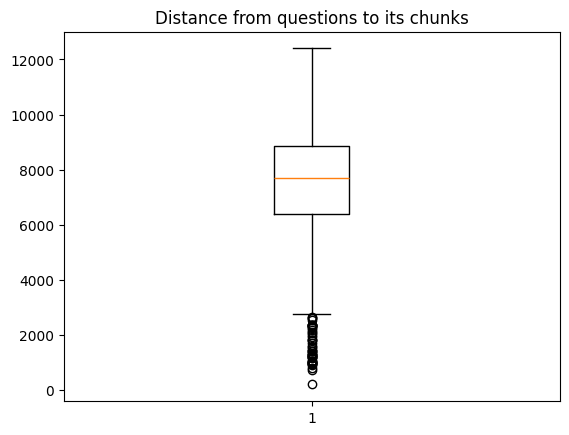

In [36]:
# Analyzing distances between questions and its chunks
distances = []
for question in questions:
    score = util.dot_score(question['question_embeddings'], question['chunk_embeddings'])
    distances.append(score[0][0])

plt.figure()
plt.title("Distance from questions to its chunks")
plt.boxplot(distances)
print("Min: ", min(distances))
print("Max: ", max(distances))
print("Mean: ", np.mean(distances))

Top 5
Min:  3128.945112408759
Max:  12917.997080668025
Mean:  7237.178210511031
Top 5 mean
Min:  3244.3450250912642
Max:  11481.09803164825
Mean:  7237.178210511031


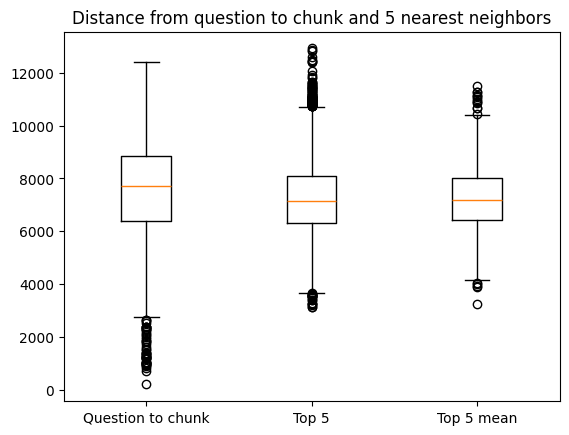

In [37]:
# Analyzing distance from each question to its K neighbors
top_k_distances = []
top_k_distances_mean = []
top_k_embeddings_idx = {}
for question in questions:
    scores = util.dot_score(question['question_embeddings'], embeddings.values)[0].tolist()
    doc_score_pairs = list(zip(data.index.tolist(), scores))

    doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

    dist = [d[1] for d in doc_score_pairs[:k]]
    idx = [d[0] for d in doc_score_pairs[:k]]

    top_k_distances.extend(dist)
    top_k_distances_mean.append(np.mean(dist))
    top_k_embeddings_idx[question['question']['id']] = idx

plt.figure()
plt.title(f"Distance from question to chunk and {k} nearest neighbors")
plt.boxplot((distances, top_k_distances, top_k_distances_mean), tick_labels=['Question to chunk', f'Top {k}', f'Top {k} mean'])
print(f"Top {k}")
print("Min: ", min(top_k_distances))
print("Max: ", max(top_k_distances))
print("Mean: ", np.mean(top_k_distances))
print(f"Top {k} mean")
print("Min: ", min(top_k_distances_mean))
print("Max: ", max(top_k_distances_mean))
print("Mean: ", np.mean(top_k_distances_mean))

# Evaluating with the dataset

In [38]:
# Analyzing percentaje of answers present in K nearest neighbors
count_in_top_k = 0
for question in questions:
    top_k_idx = top_k_embeddings_idx[question['question']['id']]
    if question['chunk_idx'] in top_k_idx:
        count_in_top_k += 1

presence_top_k = count_in_top_k/len(questions)
print(f"% of presence in top {k}: {presence_top_k}")

% of presence in top 5: 0.7819453273998729


In [39]:
# Obtaining F1@k
metrics = {
    'precisions': np.zeros((len(questions),), dtype=np.float32),
    'recalls': np.zeros((len(questions),), dtype=np.float32),
    'f1s': np.zeros((len(questions),), dtype=np.float32),
}
for q_idx, question in enumerate(questions):
    n_relevant = 0
    top_k_idx = top_k_embeddings_idx[question['question']['id']]
    all_relevant = data[(data['document_name'] == question['question']['title']) & (data['parent'] == question['question']['context'].split('/')[-1])]

    for idx in top_k_idx:
        if data.loc[idx, 'path'].lower().endswith(question['question']['context'].lower()):
            n_relevant += 1

    precision = n_relevant/k
    recall = n_relevant/len(all_relevant) if len(all_relevant) > 0 else 0
    f1 = (2*precision*recall)/(precision+recall) if precision+recall > 0 else 0

    metrics['precisions'][q_idx] = precision
    metrics['recalls'][q_idx] = recall
    metrics['f1s'][q_idx] = f1

print(f"Precision@{k}:", metrics['precisions'].mean())
print(f"Recall@{k}:", metrics['recalls'].mean())
print(f"F1@{k}:", metrics['f1s'].mean())

Precision@5: 0.16935793
Recall@5: 0.8401144
F1@5: 0.28011382


In [40]:
df_full_metrics = pd.DataFrame({'% presence': [presence_top_k], 'precision': [metrics['precisions'].mean()], 'recall': [metrics['recalls'].mean()], 'f1': [metrics['f1s'].mean()]}, index=[MODEL])

full_metrics_filename = os.path.join(RESULTS_DIR, f'mean_metrics_top_{k}.csv')
if os.path.exists(full_metrics_filename):
    prev_df_full_metrics = pd.read_csv(full_metrics_filename, sep=',', index_col=0)
    if MODEL in prev_df_full_metrics.index:
        prev_df_full_metrics.loc[MODEL] = df_full_metrics.loc[MODEL]
        full_df_full_metrics_top_k = prev_df_full_metrics
    else:
        full_df_full_metrics_top_k = pd.concat([prev_df_full_metrics, df_full_metrics], ignore_index=False)
else:
    full_df_full_metrics_top_k = df_full_metrics

full_df_full_metrics_top_k.to_csv(full_metrics_filename, sep=',')

# Evaluating by file

In [41]:
# Analyzing percentaje of answers present in K nearest neighbors
presence_top_k = []
unique_documents = data['document_name'].unique()
for file in unique_documents:
    if file in file_excludes:
        continue

    count_in_top_k = 0
    total_count = 0
    for question in filter(lambda q: q['question']['title'] == file, questions):
        top_k_idx = top_k_embeddings_idx[question['question']['id']]
        if question['chunk_idx'] in top_k_idx:
            count_in_top_k += 1
        total_count += 1

    presence = count_in_top_k/total_count
    print(f"{presence}: {file} % of presence in top {k}")
    presence_top_k.append(presence)


0.7456140350877193: ley-organica-de-la-universidad-de-guanajuato % of presence in top 5
0.7920792079207921: reglamento-del-personal-academico-de-la-universidad-de-guanajuato % of presence in top 5
0.8301886792452831: reglamento-de-distinciones-universitarias-de-la-universidad-de-guanajuato % of presence in top 5
0.9242424242424242: reglamento-de-la-junta-directiva-de-la-universidad-de-guanajuato % of presence in top 5
0.9304347826086956: reglamento-para-la-incorporacion-al-regimen-academico-de-la-universidad-de-guanajuato % of presence in top 5
0.7878787878787878: reglamento-interno-del-patronato-de-la-universidad-de-guanajuato % of presence in top 5
0.6808510638297872: reglamento-de-quienes-integran-la-orquesta-sinfonica-de-la-universidad-de-guanajuato_2021-2023 % of presence in top 5
0.8585858585858586: reglamento-academico-de-la-universidad-de-guanajuato % of presence in top 5
0.36363636363636365: codigo-de-etica-de-las-personas-servidoras-publicas-universidad-de-gunajuato % of pres

In [42]:
df_presence_top_k = pd.DataFrame({MODEL: presence_top_k}, index=unique_documents)

presence_filename = os.path.join(RESULTS_DIR, f'presence_top_{k}.csv')
if os.path.exists(presence_filename):
    prev_df_presence = pd.read_csv(presence_filename, sep=',', index_col=0)
    if MODEL in prev_df_presence.columns:
        prev_df_presence[MODEL] = df_presence_top_k[MODEL]
        full_df_presence_top_k = prev_df_presence
    else:
        full_df_presence_top_k = pd.concat([prev_df_presence, df_presence_top_k], axis=1)
else:
    full_df_presence_top_k = df_presence_top_k

full_df_presence_top_k.to_csv(presence_filename, sep=',')

In [43]:
# Obtaining F1@k
mean_precisions = []
mean_recalls = []
mean_f1s = []
for file in unique_documents:
    if file in file_excludes:
        continue

    metrics = {
        'precisions': np.zeros((len(questions),), dtype=np.float32),
        'recalls': np.zeros((len(questions),), dtype=np.float32),
        'f1s': np.zeros((len(questions),), dtype=np.float32),
    }
    for q_idx, question in enumerate(filter(lambda q: q['question']['title'] == file, questions)):
        n_relevant = 0
        top_k_idx = top_k_embeddings_idx[question['question']['id']]
        all_relevant = data[(data['document_name'] == question['question']['title']) & (data['parent'] == question['question']['context'].split('/')[-1])]

        for idx in top_k_idx:
            if data.loc[idx, 'path'].lower().endswith(question['question']['context'].lower()):
                n_relevant += 1

        precision = n_relevant/k
        recall = n_relevant/len(all_relevant) if len(all_relevant) > 0 else 0
        f1 = (2*precision*recall)/(precision+recall) if precision+recall > 0 else 0

        metrics['precisions'][q_idx] = precision
        metrics['recalls'][q_idx] = recall
        metrics['f1s'][q_idx] = f1

    mean_precision = metrics['precisions'].mean()
    mean_recall = metrics['recalls'].mean()
    mean_f1 = metrics['f1s'].mean()

    print(f"{mean_precision} Precision@{k}: {file}")
    print(f"{mean_recall} Recall@{k}: {file}")
    print(f"{mean_f1} F1@{k}: {file}")

    mean_precisions.append(mean_precision)
    mean_recalls.append(mean_recall)
    mean_f1s.append(mean_f1)

0.011824540793895721 Precision@5: ley-organica-de-la-universidad-de-guanajuato
0.05912269651889801 Recall@5: ley-organica-de-la-universidad-de-guanajuato
0.019707564264535904 F1@5: ley-organica-de-la-universidad-de-guanajuato
0.02136046253144741 Precision@5: reglamento-del-personal-academico-de-la-universidad-de-guanajuato
0.10680229216814041 Recall@5: reglamento-del-personal-academico-de-la-universidad-de-guanajuato
0.03560075908899307 F1@5: reglamento-del-personal-academico-de-la-universidad-de-guanajuato
0.006738716270774603 Precision@5: reglamento-de-distinciones-universitarias-de-la-universidad-de-guanajuato
0.033693578094244 Recall@5: reglamento-de-distinciones-universitarias-de-la-universidad-de-guanajuato
0.011231194250285625 F1@5: reglamento-de-distinciones-universitarias-de-la-universidad-de-guanajuato
0.008137318305671215 Precision@5: reglamento-de-la-junta-directiva-de-la-universidad-de-guanajuato
0.04068658500909805 Recall@5: reglamento-de-la-junta-directiva-de-la-universi

In [44]:
df_metrics = pd.DataFrame({f'{MODEL} precision': mean_precisions, f'{MODEL} recall': mean_recalls, f'{MODEL} f1': mean_f1s}, index=unique_documents)

metrics_filename = os.path.join(RESULTS_DIR, f'metrics_top_{k}.csv')
if os.path.exists(metrics_filename):
    prev_df_metrics = pd.read_csv(metrics_filename, sep=',', index_col=0)
    if MODEL in [col.split(' ')[0] for col in prev_df_metrics.columns]:
        prev_df_metrics[f'{MODEL} precision'] = df_metrics[f'{MODEL} precision']
        prev_df_metrics[f'{MODEL} recall'] = df_metrics[f'{MODEL} recall']
        prev_df_metrics[f'{MODEL} f1'] = df_metrics[f'{MODEL} f1']
        full_df_metrics = prev_df_metrics
    else:
        full_df_metrics = pd.concat([prev_df_metrics, df_metrics], axis=1)
else:
    full_df_metrics = df_metrics

full_df_metrics.to_csv(metrics_filename, sep=',')